# Predicting Fuel Consumption with Pytorch

This sample uses a quite different approach to prepreprocessing data to that found in S. Raschka´s book

In [6]:
import numpy as np
import pandas as pd
import os, sys
 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.model_selection import train_test_split 
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

import torch
from torch.nn.functional import normalize, one_hot


## 1. Import and Clean Data 

In [3]:

path_to_file = 'C:/Users/MRM/Desktop/Data_Analytics/Medium_and_PPB/Machine_Learning/Machine_Learning/Regression_Problems/Predicting_Car_Fuel_Consumption'

file = 'auto-mpg.data'

column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
                'Acceleration', 'Model Year', 'Origin']

df = pd.read_csv(os.path.join(path_to_file, file), names=column_names,
                 na_values = "?", comment='\t',
                 sep=" ", skipinitialspace=True)

df.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


In [4]:
print(df.isna().sum()) # Print number of NaN
df = df.dropna()
df = df.reset_index(drop=True)
print(df.shape)

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64
(392, 8)


In [5]:
# Split between training and test set
# It can be done with train_test_split or with pandas frac function
# train_dataset = df.sample(frac=0.8, random_state=0)
# test_dataset = df.drop(train_dataset.index)

df_train, df_test = train_test_split(df, train_size=0.8, random_state=1)
train_stats = df_train.describe().transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
MPG,313.0,23.404153,7.666909,9.0,17.5,23.0,29.0,46.6
Cylinders,313.0,5.402556,1.701506,3.0,4.0,4.0,8.0,8.0
Displacement,313.0,189.512780,102.675646,68.0,104.0,140.0,260.0,455.0
Horsepower,313.0,102.929712,37.919046,46.0,75.0,92.0,120.0,230.0
Weight,313.0,2961.198083,848.602146,1613.0,2219.0,2755.0,3574.0,5140.0
Acceleration,313.0,15.704473,2.725399,8.5,14.0,15.5,17.3,24.8
Model Year,313.0,75.929712,3.675305,70.0,73.0,76.0,79.0,82.0
Origin,313.0,1.591054,0.807923,1.0,1.0,1.0,2.0,3.0


In [13]:
# The model year need to be separated and later on to convert the years to buckets
# The origin needs to be converted to an encoding via embedding or one_hot_encoding
# The rest are normal numerical values which need to be normalized
numeric_column_names = ['Cylinders', 'Displacement','Horsepower', 'Weight','Acceleration']
bucketized_col = 'Model Year'
embed_col = 'Origin'

In [14]:
# Normalize Numerical Data and convert them to a tensor
x_train_numeric_norm = normalize(torch.tensor(df_train[numeric_column_names].values))
x_test_numeric_norm = normalize(torch.tensor(df_test[numeric_column_names].values))

In [21]:
x_train_numeric_norm.shape

torch.Size([313, 5])

In [16]:
# Embeddings for Origin
total_origin = df_train['Origin'].nunique() # Result 3
origin_encoded_train = one_hot(torch.from_numpy(df_train['Origin'].values) % total_origin)
origin_encoded_test = one_hot(torch.from_numpy(df_test['Origin'].values) % total_origin)

In [20]:
origin_encoded_train.shape

torch.Size([313, 3])

In [29]:
 # Bucketize 
boundaries = torch.tensor([73, 76, 79])
 
v = torch.tensor(df_train['Model Year'].values)
train_year_bucketized = torch.bucketize(v, boundaries, right=True)
train_year_bucketized = train_year_bucketized.unsqueeze(1)  # Add additional dimension to allow concatenation of tensors

v = torch.tensor(df_test['Model Year'].values)
test_year_bucketized = torch.bucketize(v, boundaries, right=True)
test_year_bucketized = test_year_bucketized.unsqueeze(1) 

In [30]:
train_year_bucketized.shape

torch.Size([313, 1])

In [31]:
# Join all datasets 

x_train = torch.cat((x_train_numeric_norm, origin_encoded_train,train_year_bucketized), 1).float()
x_test = torch.cat([x_test_numeric_norm, origin_encoded_test, test_year_bucketized], 1).float()

In [32]:
x_train

tensor([[1.6031e-03, 5.4106e-02, 3.3666e-02,  ..., 1.0000e+00, 0.0000e+00,
         3.0000e+00],
        [1.6535e-03, 6.2006e-02, 3.0314e-02,  ..., 1.0000e+00, 0.0000e+00,
         2.0000e+00],
        [1.7995e-03, 4.4089e-02, 3.7341e-02,  ..., 0.0000e+00, 1.0000e+00,
         1.0000e+00],
        ...,
        [1.9457e-03, 7.4667e-02, 3.1618e-02,  ..., 1.0000e+00, 0.0000e+00,
         0.0000e+00],
        [1.9471e-03, 4.7703e-02, 3.0666e-02,  ..., 1.0000e+00, 0.0000e+00,
         2.0000e+00],
        [1.8927e-03, 8.2805e-02, 3.9037e-02,  ..., 1.0000e+00, 0.0000e+00,
         0.0000e+00]])

In [23]:
y_train = torch.tensor(df_train['MPG'].values).float()
y_test = torch.tensor(df_test['MPG'].values).float()

## 2. Load tensors into DataLoader

In [33]:
from torch.utils.data import DataLoader, TensorDataset

train_ds = TensorDataset(x_train, y_train)
batch_size = 8
torch.manual_seed(1)
train_dl = DataLoader(train_ds, batch_size, shuffle=True)

In [77]:
# Create model using nn.Sequential

hidden_units = [16, 8]
input_size = x_train.shape[1]

all_layers = []
for hidden_unit in hidden_units:
    layer = torch.nn.Linear(input_size, hidden_unit)
    all_layers.append(layer)
    all_layers.append(torch.nn.ReLU())
    input_size = hidden_unit

all_layers.append(torch.nn.Linear(hidden_units[-1], 1))

model = torch.nn.Sequential(*all_layers)

model.eval()

Sequential(
  (0): Linear(in_features=9, out_features=16, bias=True)
  (1): ReLU()
  (2): Linear(in_features=16, out_features=8, bias=True)
  (3): ReLU()
  (4): Linear(in_features=8, out_features=1, bias=True)
)

In [78]:
# Define Loss and Optimizer
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Train the model

torch.manual_seed(1)
num_epochs = 400
log_epochs = 20 

loss_hist = []

for epoch in range(num_epochs):
    loss_hist_train = 0
    for x_batch, y_batch in train_dl:
        pred = model(x_batch)[:, 0]
        loss = loss_fn(pred, y_batch)
        loss.backward() # Apply gradients
        optimizer.step() # Update optimizer
        optimizer.zero_grad() # Reset gradients
        loss_hist_train += loss.item() # Update batch loss
        
    if epoch % log_epochs==0:
        # print loss every 20 epochs
        print(f'Epoch {epoch}  Loss {loss_hist_train/len(train_dl):.4f}')
        loss_hist.append(loss_hist_train/len(train_dl))

Epoch 0  Loss 620.3257
Epoch 20  Loss 28.6769
Epoch 40  Loss 28.3378
Epoch 60  Loss 27.2482
Epoch 80  Loss 27.5331
Epoch 100  Loss 27.2073
Epoch 120  Loss 26.3758
Epoch 140  Loss 26.3642
Epoch 160  Loss 25.9270
Epoch 180  Loss 27.6407
Epoch 200  Loss 24.8677
Epoch 220  Loss 24.3254
Epoch 240  Loss 25.4588
Epoch 260  Loss 23.3022
Epoch 280  Loss 22.9302
Epoch 300  Loss 23.3491
Epoch 320  Loss 21.5921
Epoch 340  Loss 21.1794
Epoch 360  Loss 20.0902
Epoch 380  Loss 20.5330


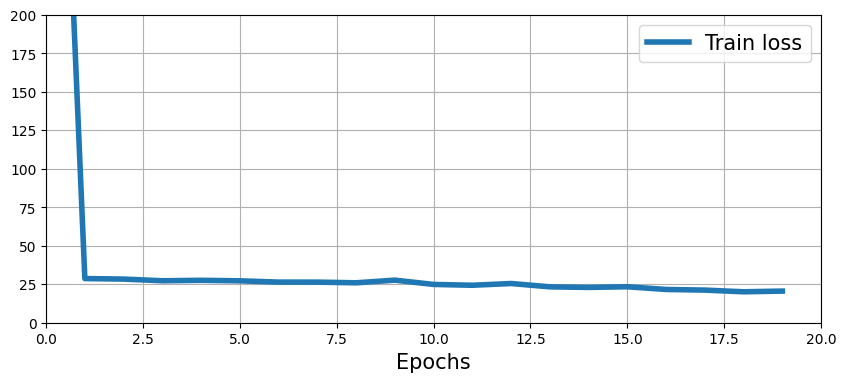

In [79]:
fig = plt.figure(figsize=(10, 4))
plt.plot(loss_hist, lw=4)
plt.legend(['Train loss'], fontsize=15)
plt.xlabel('Epochs', size=15)
plt.ylim(0,200)
plt.xlim(0,20)
plt.grid(True)
plt.show()

In [80]:
# Predictions over test set
with torch.no_grad():
    pred = model(x_test.float())[:, 0]
    loss = loss_fn(pred, y_test)
    print(f'Test MSE: {loss.item():.4f}')
    print(f'Test MAE: {torch.nn.L1Loss()(pred, y_test).item():.4f}')

Test MSE: 20.0007
Test MAE: 3.4017


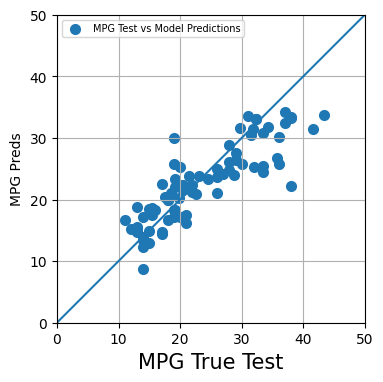

In [82]:
fig = plt.figure(figsize=(10, 4))
a = plt.axes(aspect='equal')
plt.scatter(y_test, pred, lw=2)
plt.legend(['MPG Test vs Model Predictions'], fontsize=7)
plt.xlabel('MPG True Test', size=15)
plt.ylabel('MPG Preds')
plt.grid(True)
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
plt.plot(lims, lims)
plt.show()